<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
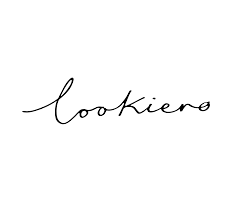    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Node classification
En este script se generan multiples modelos de clasificación de nodos

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import pickle

def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

In [2]:
import warnings
warnings.filterwarnings('ignore')

- **Pyspark**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import when

- **Strings**

In [4]:
from collections import Counter

- **Visualización**

In [5]:
import matplotlib.pyplot as plt

* **Grafos**

In [20]:
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx, train_test_split_edges

- **Otros**

In [7]:
import itertools

## Funciones a utilizar
---

In [8]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [9]:
def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [10]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

* Función para conseguir valores únicos de una variable en *pyspark*

In [11]:
def get_value(dffs, variable):
    return list(dffs.select(dffs[variable]).distinct().toPandas()[variable])

In [12]:
G7, G8, G9 = abrir_pikle('G7'), abrir_pikle('G8'), abrir_pikle('G9')

### Embeddings
---

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

In [15]:
from node2vec import Node2Vec
import gensim
gensim.__version__

'4.1.2'

In [16]:
import torch
import torch.nn.functional as F

In [17]:
from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

* Se genera el modelo para hacer el embedding

In [ ]:
node2vec = Node2Vec(G7, dimensions=64, walk_length=10, num_walks=10, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
t10cu_emb = { n: list(map(float,model.wv.get_vector(n))) for n in G7.nodes()}

* Se incluye el embedding en el nodo

In [ ]:
for x, v  in t10cu_emb.items(): G7.nodes[x]['x'] = v

* Embedding manual, es simplemente un one hot enocodding

In [18]:
for v in ['color','size','level']:
    attr = [G7.nodes[x][v] for x in G7.nodes()]

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(attr)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    guardar_pikle(onehot_encoded, 'onehot_encoded_' + v)

In [19]:
color, size, level = abrir_pikle('onehot_encoded_color'), abrir_pikle('onehot_encoded_size'), abrir_pikle('onehot_encoded_level')
encoding = np.concatenate((color, size, level), axis=1)

for k, v in enumerate(encoding.tolist()): G7.nodes[k]['x_encoded'] = v

### Node classification
---

In [21]:
G7_torch_node = from_networkx(G7)

In [22]:
train_portion = int(G7_torch_node.num_nodes * 0.7)
G7_torch_node.train_mask = torch.tensor([True] * train_portion + [False] * (G7_torch_node.num_nodes - train_portion))
G7_torch_node.test_mask = torch.tensor([False] * train_portion + [True] * (G7_torch_node.num_nodes - train_portion))
G7_torch_node.y = torch.tensor(LabelEncoder().fit_transform(G7_torch_node.color).tolist())

In [23]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(np.shape(G7_torch_node.x_encoded)[1], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, np.shape(G7_torch_node.x_encoded)[1])

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(50, 16)
  (conv2): GCNConv(16, 50)
)


In [24]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(G7_torch_node.x_encoded, G7_torch_node.edge_index)  # Perform a single forward pass.
      loss = criterion(out[G7_torch_node.train_mask], G7_torch_node.y[G7_torch_node.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(G7_torch_node.x_encoded, G7_torch_node.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[G7_torch_node.test_mask] == G7_torch_node.y[G7_torch_node.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(G7_torch_node.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 3.9372
Epoch: 002, Loss: 3.8938
Epoch: 003, Loss: 3.8469
Epoch: 004, Loss: 3.8072
Epoch: 005, Loss: 3.7601
Epoch: 006, Loss: 3.7175
Epoch: 007, Loss: 3.6640
Epoch: 008, Loss: 3.6128
Epoch: 009, Loss: 3.5705
Epoch: 010, Loss: 3.5097
Epoch: 011, Loss: 3.4473
Epoch: 012, Loss: 3.3704
Epoch: 013, Loss: 3.3349
Epoch: 014, Loss: 3.2575
Epoch: 015, Loss: 3.2039
Epoch: 016, Loss: 3.1252
Epoch: 017, Loss: 3.0671
Epoch: 018, Loss: 2.9887
Epoch: 019, Loss: 2.9435
Epoch: 020, Loss: 2.8970
Epoch: 021, Loss: 2.8422
Epoch: 022, Loss: 2.8202
Epoch: 023, Loss: 2.7682
Epoch: 024, Loss: 2.7377
Epoch: 025, Loss: 2.6942
Epoch: 026, Loss: 2.6672
Epoch: 027, Loss: 2.6345
Epoch: 028, Loss: 2.5864
Epoch: 029, Loss: 2.5673
Epoch: 030, Loss: 2.5321
Epoch: 031, Loss: 2.5036
Epoch: 032, Loss: 2.4702
Epoch: 033, Loss: 2.4596
Epoch: 034, Loss: 2.4107
Epoch: 035, Loss: 2.4042
Epoch: 036, Loss: 2.3872
Epoch: 037, Loss: 2.3415
Epoch: 038, Loss: 2.2911
Epoch: 039, Loss: 2.2942
Epoch: 040, Loss: 2.2587


In [25]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8109


In [26]:
torch.unique(G7_torch_node.y)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

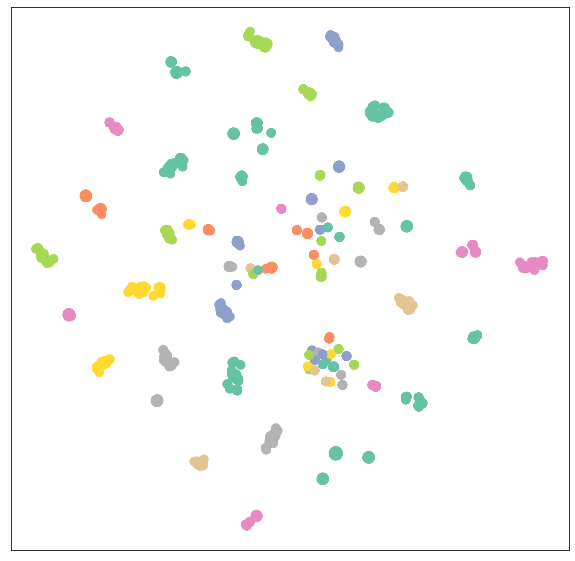

In [27]:
from sklearn.manifold import TSNE
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

   
model.eval()
out = model(G7_torch_node.x_encoded, G7_torch_node.edge_index)
visualize(out, color=G7_torch_node.y)

**Plotear grafo**